## Check the test dynamic_offset.txt files for self-consistency

The expectation is that `calc_aca_from_targ(target, y_off, z_off, SI_ALIGN)` should be the same as the `aca` coordinate.  Here `y_off` is the sum of the two offsets `target_offset_y + aca_offset_y`.

Instead there is a residual which looks like the CHARACTERISTICS offset (around -3, +11 arcsec).

A critical routine in this process is [calc_aca_from_targ](http://cxc.cfa.harvard.edu/mta/ASPECT/tool_doc/chandra_aca/_modules/chandra_aca/transform.html#calc_aca_from_targ), which is validated in the second section of this notebook.

In [2]:
from __future__ import division, print_function
from astropy.table import Table
import numpy as np
from Quaternion import Quat
import chandra_aca
from chandra_aca import calc_aca_from_targ, calc_targ_from_aca
import parse_cm
from Ska.engarchive import fetch_sci
from Chandra.Time import DateTime
%matplotlib inline

In [3]:
# SI_ALIGN from Matlab code
SI_ALIGN = chandra_aca.ODB_SI_ALIGN
SI_ALIGN

array([[  9.99999906e-01,  -3.37419984e-04,  -2.73439987e-04],
       [  3.37419984e-04,   9.99999943e-01,  -4.61320600e-08],
       [  2.73439987e-04,  -4.61320600e-08,   9.99999963e-01]])

In [4]:
def print_dq(q1, q2):
    """
    Print the difference between two quaternions
    """
    dq = q1.inv() * q2
    dr, dp, dy, _ = np.degrees(dq.q) * 2 * 3600
    print('droll={:6.2f}, dpitch={:6.2f}, dyaw={:6.2f} arcsec'.format(dr, dp, dy))

In [5]:
def check_obs(obs):
    """
    Check `obs` (which is a row out of the dynamic offsets table) for consistency
    between target and aca coordinates given the target and aca offsets and the
    SI_ALIGN alignment matrix
    """
    y_off = (obs['target_offset_y'] + obs['aca_offset_y']) / 3600
    z_off = (obs['target_offset_z'] + obs['aca_offset_z']) / 3600
    
    q_targ = Quat([obs['target_ra'], obs['target_dec'], obs['target_roll']])
    q_aca = Quat([obs['aca_ra'], obs['aca_dec'], obs['aca_roll']])
    
    q_aca_out = calc_aca_from_targ(q_targ, y_off, z_off, SI_ALIGN)
    print('Obsid={} detector={} '.format(obs['obsid'], obs['detector']), end='')
    print_dq(q_aca, q_aca_out)

In [6]:
def check_obs_vs_manvr(obs, manvr):
    """
    Check against attitude from actual flight products (from maneuver summary file)
    """
    mf = manvr['final']
    q_flight = Quat([mf['q1'], mf['q2'], mf['q3'], mf['q4']])
    q_aca = Quat([obs['aca_ra'], obs['aca_dec'], obs['aca_roll']])
    print('Obsid={} detector={} chipx={:8.2f} chipy={:8.2f} '
          .format(obs['obsid'], obs['detector'], obs['chipx'], obs['chipy']), end='')
    print_dq(q_aca, q_flight)

In [7]:
dat = Table.read('PRELIM/MAY0916-v2/MAY0916_sample_aimpoint_adjustment_file_orRaDec.txt', format='ascii')

In [8]:
dat

obsid,detector,chipx,chipy,chip_id,target_offset_y,target_offset_z,target_ra,target_dec,target_roll,aca_offset_y,aca_offset_z,aca_ra,aca_dec,aca_roll,mean_date,mean_t_ccd
int64,string48,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,string168,float64
18225,ACIS-S,200.7,467.9,7,-90.0,-18.0,227.366667,7.555556,180.000053,16.37,9.8,227.365134,7.568992,180.000199,2016:131:11:37:27.816,-15.81
17146,ACIS-I,930.2,1009.6,3,-18.0,-18.0,299.698333,40.893111,115.000109,17.15,5.32,299.723398,40.881315,114.983594,2016:131:23:55:27.816,-16.41
18310,ACIS-I,970.0,980.0,3,-18.0,-18.0,265.21363,-28.29669,81.021662,0.55,-15.21,265.218414,-28.311616,81.023872,2016:132:04:17:51.816,-15.9
18311,ACIS-I,970.0,980.0,3,-18.0,-18.0,265.46906,-28.38228,81.063,0.19,-15.39,265.473823,-28.397095,81.065206,2016:132:04:58:51.816,-15.8
18312,ACIS-I,970.0,980.0,3,-18.0,-18.0,265.5844,-28.155892,81.444554,-0.17,-15.56,265.589226,-28.170573,81.446776,2016:132:05:45:19.816,-15.71
18313,ACIS-I,970.0,980.0,3,-18.0,-18.0,265.3005,-28.155056,81.252364,-0.46,-15.7,265.305241,-28.169667,81.254545,2016:132:06:29:03.816,-15.64
18314,ACIS-I,970.0,980.0,3,-18.0,-18.0,265.09774,-28.02048,81.300125,-0.7,-15.82,265.102463,-28.035017,81.302288,2016:132:07:12:47.816,-15.57
18315,ACIS-I,970.0,980.0,3,-18.0,-18.0,265.36831,-28.03393,81.452896,-0.91,-15.92,265.373056,-28.048394,81.455071,2016:132:07:59:15.816,-15.52
18316,ACIS-I,970.0,980.0,3,-18.0,-18.0,265.64751,-28.02839,81.636608,-1.07,-16.0,265.652291,-28.042793,81.6388,2016:132:08:42:59.816,-15.48


In [9]:
# Check each observation
for obs in dat:
    check_obs(obs)

Obsid=18225 detector=ACIS-S droll=  0.19, dpitch= -0.17, dyaw= -1.44 arcsec
Obsid=17146 detector=ACIS-I droll=  0.39, dpitch= -0.17, dyaw= -1.44 arcsec
Obsid=18310 detector=ACIS-I droll=  0.21, dpitch= -0.17, dyaw= -1.44 arcsec
Obsid=18311 detector=ACIS-I droll=  0.21, dpitch= -0.17, dyaw= -1.44 arcsec
Obsid=18312 detector=ACIS-I droll=  0.20, dpitch= -0.17, dyaw= -1.44 arcsec
Obsid=18313 detector=ACIS-I droll=  0.21, dpitch= -0.17, dyaw= -1.44 arcsec
Obsid=18314 detector=ACIS-I droll=  0.20, dpitch= -0.17, dyaw= -1.44 arcsec
Obsid=18315 detector=ACIS-I droll=  0.20, dpitch= -0.17, dyaw= -1.44 arcsec
Obsid=18316 detector=ACIS-I droll=  0.20, dpitch= -0.17, dyaw= -1.44 arcsec
Obsid=18317 detector=ACIS-I droll=  0.20, dpitch= -0.17, dyaw= -1.44 arcsec
Obsid=18318 detector=ACIS-I droll=  0.20, dpitch= -0.17, dyaw= -1.44 arcsec
Obsid=18319 detector=ACIS-I droll=  0.20, dpitch= -0.17, dyaw= -1.44 arcsec
Obsid=18320 detector=ACIS-I droll=  0.21, dpitch= -0.17, dyaw= -1.44 arcsec
Obsid=18108 

In [10]:
import parse_cm.maneuver

In [12]:
mm = parse_cm.maneuver.read_maneuver_summary('PRELIM/MAY0916-v2/flight/mps/mm130_1307.sum', structured=True)
mm = {m['final']['id']: m for m in mm}  # Turn into a dict

In [13]:
mm[1714600]['final']

{'attitude_type': 'FINAL',
 'date': '2016:131:20:26:06.616',
 'dec': 40.88244014,
 'id': 1714600,
 'off_nominal_roll': 0.23845891,
 'q1': 0.589146966718,
 'q2': -0.559084751746,
 'q3': 0.001864374168,
 'q4': 0.583375193234,
 'ra': 299.7216364,
 'roll': 114.98474486,
 'sun_angle': 91.44183616}

In [14]:
for obs in dat:
    if obs['chipx'] == 970.0:
        continue  # these are fake test cases
    check_obs_vs_manvr(obs, mm[obs['obsid'] * 100])

Obsid=18225 detector=ACIS-S chipx=  200.70 chipy=  467.90 droll= -0.00, dpitch= -6.43, dyaw=  2.43 arcsec
Obsid=17146 detector=ACIS-I chipx=  930.20 chipy= 1009.60 droll= -0.01, dpitch= -2.64, dyaw=  5.70 arcsec
Obsid=18108 detector=ACIS-S chipx=  200.70 chipy=  467.90 droll= -0.00, dpitch= -5.60, dyaw=  0.73 arcsec
Obsid=18848 detector=ACIS-S chipx=  200.70 chipy=  467.90 droll=  0.00, dpitch= -4.05, dyaw= -2.45 arcsec
Obsid=17469 detector=ACIS-S chipx=  200.70 chipy=  467.90 droll=  0.01, dpitch= -4.69, dyaw= -0.84 arcsec
Obsid=17106 detector=ACIS-I chipx=  930.20 chipy= 1009.60 droll=  0.00, dpitch= -0.63, dyaw=  1.27 arcsec
Obsid=17761 detector=ACIS-S chipx=  200.70 chipy=  467.90 droll=  0.01, dpitch= -4.74, dyaw=  0.45 arcsec
Obsid=16971 detector=ACIS-S chipx=  200.70 chipy=  467.90 droll=  0.00, dpitch= -6.05, dyaw=  1.65 arcsec
Obsid=17212 detector=ACIS-I chipx=  930.20 chipy= 1009.60 droll= -0.00, dpitch= -0.88, dyaw=  2.11 arcsec
Obsid=18141 detector=ACIS-S chipx=  200.70 chi

In [15]:
orl = parse_cm.or_list.read_or_list('PRELIM/MAY0916-v2/flight/MAY0916_A.or')

In [16]:
orl = {o['obsid']: o for o in orl}

In [17]:
orl[17146]

{'dither_on': 'ON',
 'dither_y_amp': 0.002222,
 'dither_y_freq': 0.0,
 'dither_y_phase': 0.5091,
 'dither_z_amp': 0.36,
 'dither_z_freq': 0.002222,
 'dither_z_phase': 0.0,
 'duration': 25000.0,
 'grating': 'NONE',
 'obsid': 17146,
 'priority': 6,
 'si': 'ACIS-I',
 'si_mode': 'TE_006E6',
 'sim_offset_x': 0,
 'sim_offset_z': 0,
 'target_dec': 40.893111,
 'target_name': 'Cygnus A - NW Subclu',
 'target_offset_y': -0.005,
 'target_offset_z': -0.005,
 'target_ra': 299.698333}

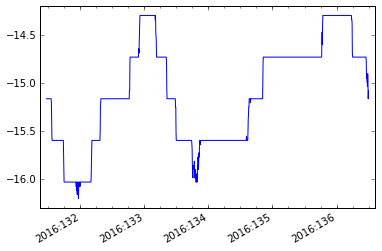

In [18]:
start, stop = dat[0]['mean_date'], dat[-1]['mean_date']
tccd = fetch_sci.Msid('aacccdpt', start, stop, stat='5min')
tccd.plot()

-14.7691


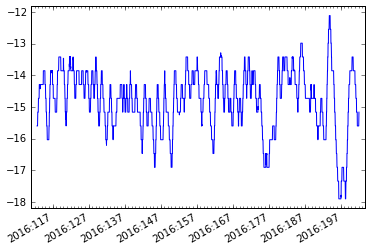

In [19]:
tccd2 = fetch_sci.Msid('aacccdpt', DateTime()-90, DateTime(), stat='5min')
tccd2.plot()
print(np.mean(tccd2.vals))

## Validate calc_aca_from_targ() using JUN0115 obsid 17058.

Validate the Ska function to transform from target coordinates to ACA pointing assuming an SI_ALIGN matrix and Y/Z offsets.

From the OR and maneuver summary file
```
OBS,
 ID=17058,TARGET=(215.015417,-49.595083,{PKS B1416-493}),
 DURATION=(64000.000000),PRIORITY=5,SI=ACIS-I,GRATING=NONE,SI_MODE=TE_00458,
 ROLL=(305.0),
 ACA_MODE=DEFAULT,TARGET_OFFSET=(-0.009167,0.001667),
 DITHER=(ON,0.002222,0.360000,0.000000,0.002222,0.509100,0.000000),
 SEGMENT=(1,58800.000000),PRECEDING=(P8504),MIN_ACQ=1,MIN_GUIDE=1
 
 
   FINAL ID:    1705800
                       FINAL ATTITUDE
      STOP TIME (GMT):   2015:154:22:57:25.930
             RA (deg):    214.98451436
            DEC (deg):    -49.59669395
           ROLL (deg):    304.97646792
        Dev. from
      Opt. Roll (deg):     -4.70028676
      Sun Angle (deg):    140.49525748
           Quaternion:      0.228750858213    0.511758087381   -0.709666300958    0.426790869340

```

In [20]:
q_aca = Quat([0.228750858213,    0.511758087381,   -0.709666300958,    0.426790869340])
q_targ = Quat([215.015417,-49.595083, q_aca.roll])  # approximation, but OK here
y_off, z_off = -0.009167,0.001667

In [21]:
q_aca_out = calc_aca_from_targ(q_targ, y_off, z_off, SI_ALIGN)

In [22]:
print_dq(q_aca, q_aca_out)

droll=-84.72, dpitch= -0.02, dyaw= -0.03 arcsec


#### Conclusion:  calc_aca_from_targ is working correctly

In [23]:
q_aca = Quat([0, 89.999, 0])
q_aca.equatorial

array([  0.   ,  89.999,   0.   ])

In [24]:
q_targ = calc_targ_from_aca(q_aca, 0.01, 0.0)
print(q_targ.equatorial)

[ 116.56596786   89.96720474  243.43403103]


In [25]:
q_targ0 = Quat([q_targ.ra, q_targ.dec, 0.0])

In [26]:
dq = q_aca.inv() * q_targ
dq.q

array([ -1.19310705e-08,  -1.36719996e-04,   2.55976456e-04,
         9.99999958e-01])

In [27]:
dq0 = q_aca.inv() * q_targ0
dq0.q

array([  8.50654977e-01,   1.45870633e-04,   2.50874594e-04,
         5.25724287e-01])

In [28]:
1.367e-4 * 205000.

28.0235